In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/FinalProject
IMAGE_PATH='images/'

/content/drive/.shortcut-targets-by-id/1bXi9uXJlRd3MyzEZQERAL3lIrx8FkT26/FinalProject


# Bifurcation
Changes in the qualitative behavior of the dynamical system over changes of their <b>parameters</b> are called <b>bifurcations</b>. Parameters differ depending on a domain. i.e. • Desired speed for individuals • Distance to obstacles • Width of doors • Number of pedestrians in a room can be parameters in crowd dynamics.

In [3]:
%load_ext autoreload
%autoreload 2
!pip install pytorch-lightning==0.7.6 > /dev/null
import pytorch_lightning as pl
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
import math
from scipy.integrate import solve_ivp
from util import *

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate data for training
We want to learn bifurcation given in Exercise 3.

$\dot{x_1} = \alpha x_1 - x_2 - x_1(x_1^2 + x_2^2)$, <br />
$\dot{x_2} = x_1 + \alpha x_2 - x_2(x_1^2 + x_2^2)$,
<br />
Therefore, we generate ground truth data for this dynamical system with $ scipy.integrate.solve_ivp$ for initial point $(0,2)$

The dataset generated is saved into a file called "data_tensor.pt"

If there already exists a dataset created by passing the function False we use the existing dataset in the "data_tensor.pt" file.

In [4]:
def get_data(create = False):
  if create == True:
    # LOAD FROM DATASET. data is generated in cuda from. use "map_location=torch.device('cpu')" if you want to load into cpu
    '''
      alphas are between -2 and 2 in the generated dataset.
    '''
    BIFURCATION_DATASET = generate_data().to(device) #torch.load('BIFURCATION_DATASET_n_250_dt_100.pt', map_location=torch.device('cpu')) # 
    #BIFURCATION_DATASET = BIFURCATION_DATASET.to('cpu')

    #Save the dataset into a file so that you dont have to generate it again:
    torch.save(BIFURCATION_DATASET, "data_tensor.pt")
  else:
    BIFURCATION_DATASET = torch.load("data_tensor_new_small.pt")
  return BIFURCATION_DATASET

In [72]:
BIFURCATION_DATASET = get_data(create=False)

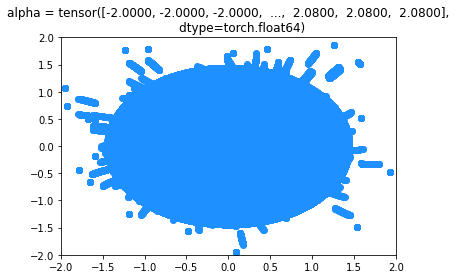

In [ ]:
# BIFURCATION_DATASET NX3
# PLOT ALL TRAJECTORIES
plot_generated_data(BIFURCATION_DATASET.cpu())

# Euler Class creation

Create the Euler class with the given dimensions.
Several Important factors change on the output has not been analyzed. This includes:


*   Larger than 256 hidden dimension
*   Usage of bias in hidden layers
*   Number of hidden layers, we only know that it performs better with more than 2 hidden layers.






In [5]:
class Eueler(nn.Module):
    def __init__(self, input_size=3, output_size=2, hidden_size = 64):
        """
        param D: dimension of state variable X
        param H: hiddensize
        """
        super(Eueler, self).__init__()
        self.M = input_size
        self.D = output_size
        self.H = hidden_size

        self.linear_input = nn.Linear(self.M, self.H,bias=True)
        self.linear_hidden1 = nn.Linear(self.H, self.H,bias=True)
        self.linear_hidden2 = nn.Linear(self.H, self.H,bias=True)
        self.linear_hidden3 = nn.Linear(self.H, self.H,bias=True)
        self.linear_hidden4 = nn.Linear(self.H, self.H,bias=True)
        self.linear_output = nn.Linear(self.H, self.D,bias=True)
        
    def forward(self, X, dt):
        """
        param X: (N,M) Initial points with correspoding operating parameters
        param t: Delta(t)
        """

        # Black box
        f = self.linear_input(X)
        #for k in range(3):
        #  f = self.linear_hidden(F.relu(f))
        f = self.linear_hidden1(F.relu(f))
        f = self.linear_hidden2(F.relu(f))
        f = self.linear_hidden3(F.relu(f))
        f = self.linear_hidden4(F.relu(f))
        f = self.linear_output(f)

        # Integrator
        x_1 = X[:,:self.D] + f * (torch.from_numpy(np.ones_like(f.shape)) * dt).to(device)

        return f, x_1

# Runge Kutta

Runge kutta model is pretty similar (in this first prototype identical) to the euler model. This is because the models predict different things. This model results only indiretly effects the next point. The result here is what we use for each "k" values calculation. It is what hf(input, parameters) is. Therefore this will be called 4 times for each prediction. (so we might want to keep the number of parameters low initially)

In [6]:
class RungeKutta(nn.Module):
    def __init__(self, input_size=3, output_size=2, hidden_size = 64):
        """
        y=xAT

        param D: dimension of X
        param H: hiddensize
        """
        super(RungeKutta, self).__init__()
        self.M = input_size
        self.D = output_size
        self.H = hidden_size

        self.linear_input = nn.Linear(self.M, self.H,bias=True)
        self.linear_hidden1 = nn.Linear(self.H, self.H,bias=True)
        self.linear_hidden2 = nn.Linear(self.H, self.H,bias=True)
        self.linear_hidden3 = nn.Linear(self.H, self.H,bias=True)
        self.linear_hidden4 = nn.Linear(self.H, self.H,bias=True)
        self.linear_output = nn.Linear(self.H, self.D,bias=True)

    def forward(self, X, dt):
        """
        param x_0: (N,D) Initial points
        param t: Delta(t)
        """
        # Black box
        def black_box(X):
          f = self.linear_input(X)
          f = self.linear_hidden1(F.relu(f))
          f = self.linear_hidden2(F.relu(f))
          f = self.linear_hidden3(F.relu(f))
          f = self.linear_hidden4(F.relu(f))
          f = self.linear_output(f)

          return f

        f = black_box(X)  # NxM => NxD
        y_pred = f
        h = (torch.from_numpy(np.ones_like(y_pred.shape)) * dt).to(device)

        k1 = torch.zeros_like(X).to(device)  # to add k1 onto x, they need to be same size though
        k1[:, :y_pred.shape[1]] = y_pred * h
        # Add it to x and get another prediction, this time for k2
        y_pred = black_box(X + k1 / 2)  # NxM => NxD
        k2 = torch.zeros_like(X).to(device)  # to add k1 onto x, they need to be same size though
        k2[:, :y_pred.shape[1]] = y_pred * h
        # k3:
        y_pred = black_box(X + k2 / 2)  # NxM => NxD
        k3 = torch.zeros_like(X).to(device)  # to add k1 onto x, they need to be same size though
        k3[:, :y_pred.shape[1]] = y_pred * h
        # k4:
        y_pred = black_box(X + k3).to(device)  # NxM => NxD
        k4 = torch.zeros_like(X)  # to add k1 onto x, they need to be same size though
        k4[:, :y_pred.shape[1]] = y_pred * h

        x_1 = X[:, :self.D] + 1 / 6 * (k1[:, :self.D] + 2 * k2[:, :self.D] + 2 * k3[:, :self.D] + k4[:, :self.D])


        return f, x_1

In [73]:
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html


def euler_model(input_size=3,output_size=2,hidden_size=128):
  model = Eueler(input_size=input_size,output_size=output_size,hidden_size=hidden_size).to(device)
  loss_fn = nn.MSELoss()
  learning_rate = 1e-4
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return model, loss_fn, optimizer

def rungekutta_model(input_size=3,output_size=2,hidden_size=128):
  model = RungeKutta(input_size=input_size,output_size=output_size,hidden_size=hidden_size).to(device)
  loss_fn = nn.MSELoss()
  learning_rate = 1e-4
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return model, loss_fn, optimizer


# These are two functions that can be used for both Euler method and Runge Kutta.

The prediction function, which creates a meshgrid between -2 and 2, hence if you are predicting values not in range be careful with this part!

The Phase portrait plot function, which is actually used by the function phase_check()

In [8]:
def get_predictions(alpha,model):
  x = np.arange(-2, 2, 0.01)
  x1, x2 = np.meshgrid(x, x)
  X_0 = np.vstack((x1.flatten(), x2.flatten())).T

  A = np.array([[alpha]*len(X_0)]).T
  X = np.append(X_0, A, axis=1)
  X = torch.from_numpy(X).float().to(device) # use np.column_stack([X_0, alpha]) instead

  dt = torch.tensor(0.1).to(device).float()
  f, _ = model(X, dt)
  f = f.cpu().detach().numpy()
  y1 = f[:,0].reshape(x1.shape)
  y2 = f[:,1].reshape(x2.shape)

  return (x1, x2, y1, y2)


def plot_phase_portrait(ax, pred, alpha):
  ax.streamplot(*pred, color='dodgerblue', linewidth=1)
  ax.set_title("alpha = {}".format(alpha))
  ax.set_xlim([-2,2])
  ax.set_ylim([-2,2])

def single_trajectory(model):
  pass
    

# Training function for Euler
To fix the memory issue:
1) Torch no grad for validation
2)before validation torch.eval()
PS: the validation does not seem to have any no batch or anything, might be good to have a more structured validation. (so that we can implement torch.no_grad and torch.eval() more clearly)
https://www.kaggle.com/c/bengaliai-cv19/discussion/133119

In [9]:
def plot_loss_curve(val_loss_arr):
  plt.plot(val_loss_arr)
  plt.xlabel("Number of epoch")
  plt.ylabel("Loss")
  plt.show()

In [10]:
"""
FULL TRAINING PROCEDURE FOR EULER
ASSUME WE HAVE `BIFURCATION_DATASET`
ALL OTHER OPERATIONS WILL BE DONE IN THIS BLOCK FOR TRAINING
"""
def train_euler(BIFURCATION_DATASET, epochs = 1000, H = 128):
  import time
  print("BIFURCATION_DATASET.shape {}".format(BIFURCATION_DATASET.shape))
  N = len(BIFURCATION_DATASET) # Size of dataset

  M=3   # input_size
  D=2   # output_size
  H=H # hidden_size
  model, loss_fn, optimizer = euler_model(M, D, H) # defaults: input_size=3, output_size=2, hidden_size=128

  num_train, num_val, num_test = int(N * 0.6), int(N * 0.3), int(N * 0.1)

  np.random.seed(0)
  indices = np.random.permutation(N)
  train_idx, val_idx, test_idx = indices[:num_train], indices[num_train:num_train + num_val], indices[num_train + num_val:]
  #print("BIFURCATION_DATASET.shape {}".format(BIFURCATION_DATASET.shape))
  batch_size = 32
  batch_num = math.floor(N/batch_size)
  #print("train_idx {}".format(train_idx))
  batched_train_idxs = np.array_split(train_idx, batch_num)
  #print("batched_train_idxs.shape {}".format(batched_train_idxs))
  X = BIFURCATION_DATASET[:,:M]
  X_1 = BIFURCATION_DATASET[:,M:]
  
  val_loss_arr = []
  
  dt = torch.tensor(0.1).to(device).float()
  for t in range(epochs):
    train_epoch_loss = 0.0
    seconds = time.time()
    for batch_idx in batched_train_idxs:
      x_0_with_alpha = X[batch_idx].float()
      x_1 = X_1[batch_idx].float()

      _, y_pred = model(x_0_with_alpha, dt) # NxM => NxD

      # Compute and print loss.
      loss = loss_fn(y_pred, x_1)
      train_epoch_loss += loss

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

    model.eval()
    with torch.no_grad():
      train_epoch_loss /= len(train_idx)
      _, pred = model(X[val_idx].float(), dt)
      validation_loss = loss_fn(pred, X_1[val_idx].float())
      val_loss_arr.append(validation_loss)
      print('(Epoch %d / %d, seconds: %d) train loss: %f validation loss: %f' % (t + 1, epochs, (time.time()-seconds), train_epoch_loss, validation_loss))
    model.train()
  plot_loss_curve(val_loss_arr)
  return model

# Runge Kutta:

Runge kutta has the following architecture:

<img width="800" src="https://drive.google.com/file/d/1tpBHXdeyZNhurTlL-AXyweBwWU65pxSb/view?usp=sharing" />

So we will call the same network multiple times, each by adding onto x data the previous k. At the end we will sum them all to get the ground truth.

In [11]:
"""
FULL TRAINING PROCEDURE FOR RUNGE-KUTTA
ASSUME WE HAVE `BIFURCATION_DATASET`
ALL OTHER OPERATIONS WILL BE DONE IN THIS BLOCK FOR TRAINING
"""
def train_rungekutta(BIFURCATION_DATASET, epochs = 1000, H = 128):
  import time
  print("BIFURCATION_DATASET.shape {}".format(BIFURCATION_DATASET.shape))
  N = len(BIFURCATION_DATASET) # Size of dataset

  M=3   # input_size
  D=2   # output_size
  H=H # hidden_size
  model, loss_fn, optimizer = rungekutta_model(M, D, H) # defaults: input_size=3, output_size=2, hidden_size=128

  num_train, num_val, num_test = int(N * 0.6), int(N * 0.3), int(N * 0.1)

  np.random.seed(0)
  indices = np.random.permutation(N)
  train_idx, val_idx, test_idx = indices[:num_train], indices[num_train:num_train + num_val], indices[num_train + num_val:]
  #print("BIFURCATION_DATASET.shape {}".format(BIFURCATION_DATASET.shape))
  batch_size = 32
  batch_num = math.floor(N/batch_size)
  #print("train_idx {}".format(train_idx))
  batched_train_idxs = np.array_split(train_idx, batch_num)
  #print("batched_train_idxs.shape {}".format(batched_train_idxs))
  X = BIFURCATION_DATASET[:,:M]
  X_1 = BIFURCATION_DATASET[:,M:]
  val_loss_arr = []

  dt = torch.tensor(0.1).to(device).float()
  for t in range(epochs):
    train_epoch_loss = 0.0
    seconds = time.time()
    for batch_idx in batched_train_idxs:
      x_0_with_alpha = X[batch_idx].float()
      x_1 = X_1[batch_idx].float()

      #find k1,
      f, prediction = model(x_0_with_alpha, dt) # NxM => NxD

      # Compute and print loss.
      loss = loss_fn(prediction, x_1)
      train_epoch_loss += loss

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

    model.eval()
    with torch.no_grad():
      train_epoch_loss /= len(train_idx)
      _, pred = model(X[val_idx].float(), dt)
      validation_loss = loss_fn(pred, X_1[val_idx].float())
      val_loss_arr.append(validation_loss)
      print('(Epoch %d / %d, seconds: %d) train loss: %f validation loss: %f' % (t + 1, epochs, (time.time()-seconds), train_epoch_loss, validation_loss))
    model.train()
  plot_loss_curve(val_loss_arr)
  return model

In [12]:
def phase_check_rungekutta(model):
  #alphas = np.random.uniform(-2,2, 10)
  alphas = [-1.0, 0.0, 1.0, 2.0]
  fig, axs = plt.subplots(1,len(alphas), figsize=(16,4))

  for i, a in enumerate(alphas):
    x = np.arange(-2, 2, 0.01)
    x1, x2 = np.meshgrid(x, x)
    X_0 = np.vstack((x1.flatten(), x2.flatten())).T

    A = np.array([[a]*len(X_0)]).T
    X = np.append(X_0, A, axis=1)
    X = torch.from_numpy(X).float().to(device) # use np.column_stack([X_0, alpha]) instead

    dt = torch.tensor(0.1).to(device).float()

    f, y_pred = model(X, dt) # NxM => NxD
    
    y1 = f[:,0]
    y2 = f[:,1]

    y1 = (y1.cpu()).detach().numpy()
    y2 = (y2.cpu()).detach().numpy()
    #x1.to(device)
    #x2.to(device)
    y1 = y1.reshape(x1.shape)
    y2 = y2.reshape(x2.shape)
    pred = (x1, x2, y1, y2)
    plot_phase_portrait(axs[i], pred, a)

  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.show()

In [13]:
#alphas = [-1.0, 0.0, 1.0, 2.0]
def phase_check(model):
  #alphas = np.random.uniform(-2,2, 10)
  alphas = [-1.0, 0.0, 1.0, 2.0]
  fig, axs = plt.subplots(1,len(alphas), figsize=(16,4))

  for i, a in enumerate(alphas):
    pred = get_predictions(a, model)
    x1, x2, y1, y2 = pred
    plot_phase_portrait(axs[i], pred, a)

  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.show()

# Train Runge-kutta

In [76]:
# CREATE NEW
#trained_model_runge = train_rungekutta(BIFURCATION_DATASET, 50, 128)
#torch.save(trained_model_runge.state_dict(),'./rungekuttamodel.pt')


# LOAD EXISTING
trained_model_runge, _, _ = rungekutta_model()
trained_model_runge.load_state_dict(torch.load('rungekuttamodel_150epoch.pt'))
trained_model_runge.eval()

RungeKutta(
  (linear_input): Linear(in_features=3, out_features=128, bias=True)
  (linear_hidden1): Linear(in_features=128, out_features=128, bias=True)
  (linear_hidden2): Linear(in_features=128, out_features=128, bias=True)
  (linear_hidden3): Linear(in_features=128, out_features=128, bias=True)
  (linear_hidden4): Linear(in_features=128, out_features=128, bias=True)
  (linear_output): Linear(in_features=128, out_features=2, bias=True)
)

# Phase check Runge Kutta

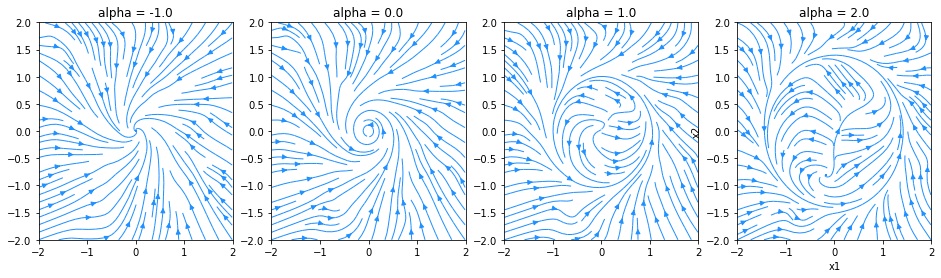

In [ ]:
phase_check_rungekutta(trained_model_runge)

BIFURCATION_DATASET.shape torch.Size([645605, 5])
(Epoch 1 / 100, seconds: 190) train loss: 0.000110 validation loss: 0.000895
(Epoch 2 / 100, seconds: 188) train loss: 0.000045 validation loss: 0.000857
(Epoch 3 / 100, seconds: 188) train loss: 0.000042 validation loss: 0.000833
(Epoch 4 / 100, seconds: 189) train loss: 0.000039 validation loss: 0.000803
(Epoch 5 / 100, seconds: 190) train loss: 0.000038 validation loss: 0.000776
(Epoch 6 / 100, seconds: 190) train loss: 0.000037 validation loss: 0.000745
(Epoch 7 / 100, seconds: 190) train loss: 0.000036 validation loss: 0.000728
(Epoch 8 / 100, seconds: 190) train loss: 0.000035 validation loss: 0.000708
(Epoch 9 / 100, seconds: 188) train loss: 0.000035 validation loss: 0.000695
(Epoch 10 / 100, seconds: 190) train loss: 0.000034 validation loss: 0.000683
(Epoch 11 / 100, seconds: 190) train loss: 0.000034 validation loss: 0.000667
(Epoch 12 / 100, seconds: 190) train loss: 0.000034 validation loss: 0.000662
(Epoch 13 / 100, second

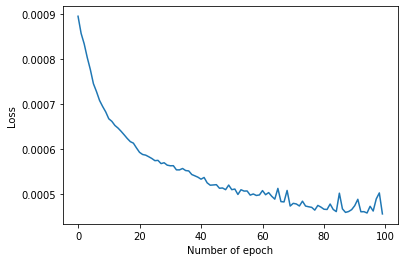

In [ ]:
trained_model_runge_2 = train_rungekutta(BIFURCATION_DATASET, 100, 128)
torch.save(trained_model_runge_2.state_dict(),'./rungekuttamodel_100epoch.pt')

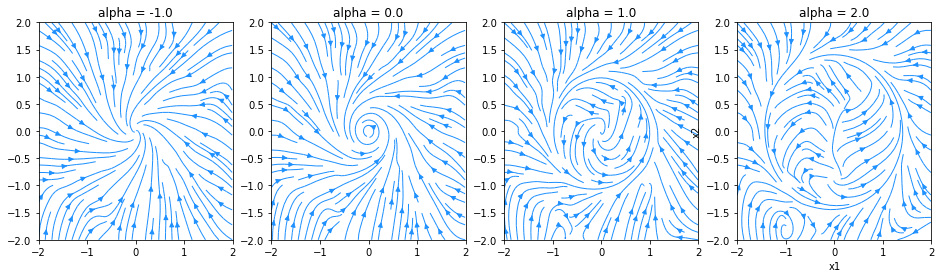

In [ ]:
phase_check_rungekutta(trained_model_runge_2)

# Train Euler

In [ ]:
trained_model_euler = train_euler(BIFURCATION_DATASET, 50, 128)

In [ ]:
phase_check(trained_model_euler)

In [ ]:
torch.save(trained_model_euler.state_dict(),'./eulermodel.pt')

BIFURCATION_DATASET.shape torch.Size([645605, 5])
(Epoch 1 / 100, seconds: 85) train loss: 0.000105 validation loss: 0.000853
(Epoch 2 / 100, seconds: 85) train loss: 0.000044 validation loss: 0.000800
(Epoch 3 / 100, seconds: 85) train loss: 0.000041 validation loss: 0.000776
(Epoch 4 / 100, seconds: 84) train loss: 0.000039 validation loss: 0.000744
(Epoch 5 / 100, seconds: 84) train loss: 0.000038 validation loss: 0.000721
(Epoch 6 / 100, seconds: 84) train loss: 0.000037 validation loss: 0.000709
(Epoch 7 / 100, seconds: 85) train loss: 0.000036 validation loss: 0.000699
(Epoch 8 / 100, seconds: 84) train loss: 0.000035 validation loss: 0.000690
(Epoch 9 / 100, seconds: 85) train loss: 0.000034 validation loss: 0.000679
(Epoch 10 / 100, seconds: 84) train loss: 0.000034 validation loss: 0.000666
(Epoch 11 / 100, seconds: 85) train loss: 0.000033 validation loss: 0.000656
(Epoch 12 / 100, seconds: 85) train loss: 0.000033 validation loss: 0.000644
(Epoch 13 / 100, seconds: 84) train

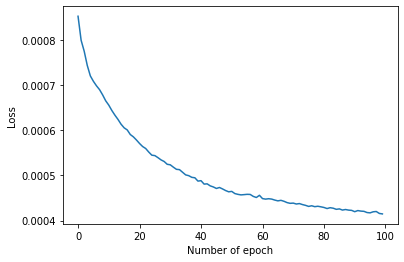

NameError: ignored

In [ ]:
trained_model_euler_2 = train_euler(BIFURCATION_DATASET, 100, 128)


In [ ]:
torch.save(trained_model_euler_2.state_dict(),'./eulermodel_100epoch.pt')

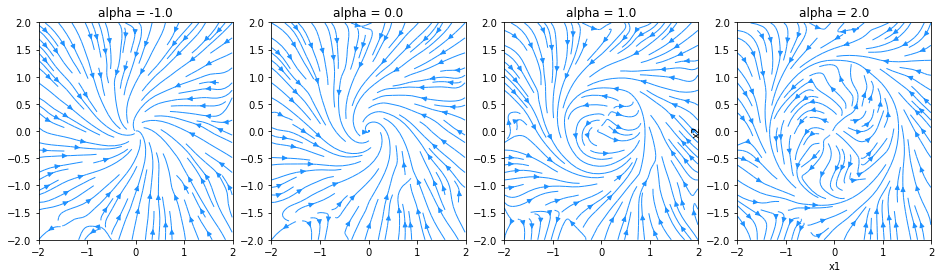

In [ ]:
phase_check(trained_model_euler_2)

In [ ]:
trained_model_euler_3 = train_euler(BIFURCATION_DATASET, 150, 128)
torch.save(trained_model_euler_3.state_dict(),'./eulermodel_150epoch.pt')

BIFURCATION_DATASET.shape torch.Size([645605, 5])
(Epoch 1 / 150, seconds: 49) train loss: 0.000105 validation loss: 0.000814
(Epoch 2 / 150, seconds: 49) train loss: 0.000043 validation loss: 0.000762
(Epoch 3 / 150, seconds: 53) train loss: 0.000040 validation loss: 0.000733
(Epoch 4 / 150, seconds: 54) train loss: 0.000038 validation loss: 0.000713
(Epoch 5 / 150, seconds: 55) train loss: 0.000037 validation loss: 0.000695


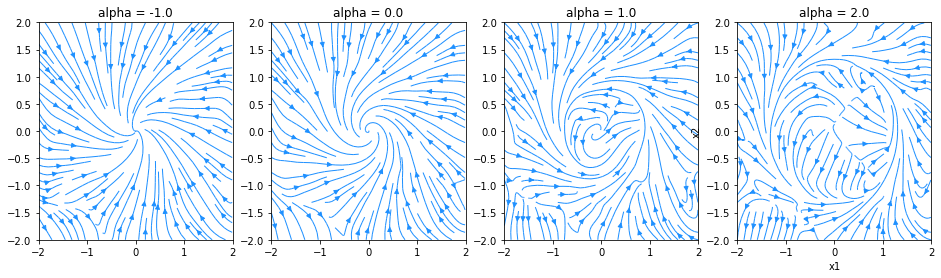

In [ ]:
phase_check(trained_model_euler_3)

In [77]:
# LOAD EXISTING EULER
trained_model_euler_3, _, _ = euler_model()
trained_model_euler_3.load_state_dict(torch.load('eulermodel_150epoch.pt'))
trained_model_euler_3.eval()

Eueler(
  (linear_input): Linear(in_features=3, out_features=128, bias=True)
  (linear_hidden1): Linear(in_features=128, out_features=128, bias=True)
  (linear_hidden2): Linear(in_features=128, out_features=128, bias=True)
  (linear_hidden3): Linear(in_features=128, out_features=128, bias=True)
  (linear_hidden4): Linear(in_features=128, out_features=128, bias=True)
  (linear_output): Linear(in_features=128, out_features=2, bias=True)
)

In [85]:
def get_trajectory_with_alpha(model, point, dt, duration = 10):
  time_step = dt
  points = np.empty((1, 5))
  t = 0
  p = np.array(point)

  torch_time_step = torch.tensor(time_step).to(device).float()

  while t < duration:
      f, x_1 = model(torch.from_numpy(p.reshape(1, 3)).to(device).float(), torch_time_step)
      x_1 = x_1.cpu().detach().numpy()

      row = np.append(p, x_1).reshape(1, 5)

      points = np.vstack((points, row))

      p = x_1
      t += time_step
      
  return torch.from_numpy(points).float()

trajectory_1 = get_trajectory_with_alpha(trained_model_euler_3, [2,0, -1], 0.1, 100)
trajectory_2 = get_trajectory_with_alpha(trained_model_euler_3, [2,0, 0], 0.1, 100)
trajectory_3 = get_trajectory_with_alpha(trained_model_euler_3, [2,0, 1], 0.1, 100)

visualize_trajectories([trajectory_1,trajectory_2,trajectory_3], [[2, 0], [2, 0], [2, 0]], x_lim=-2, y_lim=2)

ValueError: ignored

<img width="800" src="https://drive.google.com/uc?export=view&id=18_ENcBvsKo2FYW1OIYws_bI_aD3LcbHx" />

# Generate Spiral Function

In [14]:
def vector_field_ellipse(t, x):
    v = [-x[1], x[0] / 2]
    return v


def vector_field_spiral(t, x):
    v = [-0.1 * x[0] - 0.5 * x[1], 0.5 * x[0] - 0.1 * x[1]]
    return v

In [15]:
def generate_trajectory_by_ivp_func(start_point, fun=vector_field_spiral, alpha=None, duration=100):
    """

    :param start_point: Array [x, y]
    :param alpha:
    :param duration:
    :return:
    """
    t = 0
    if alpha is None:
        sol = solve_ivp(fun, [t, t + duration + 1], np.array(start_point))

        x_0 = sol.y[:, :-1].T
        x_1 = sol.y[:, 1:].T

        x_0_train = torch.from_numpy(x_0).float()
        x_1_train = torch.from_numpy(x_1).float()

        return torch.cat([x_0_train, x_1_train], dim=1)
    else:
        sol = solve_ivp(fun, [t, t + duration + 1], np.array(start_point), args=(alpha,))
        x_0 = sol.y[:, :-1].T
        x_1 = sol.y[:, 1:].T
        ax = np.array([[alpha] * len(x_0)]).T
        x_0_train = torch.from_numpy(np.append(x_0, ax, axis=1)).float()
        x_1_train = torch.from_numpy(np.append(x_1, ax, axis=1)).float()

        return torch.cat([x_0_train, x_1_train[:, :2]], dim=1)

In [16]:
def generate_data_for_non_parameterized_dynamical_system(num_points, fun=vector_field_ellipse, duration=100,
                                                         show_plot=True):
    """
    The purpose of this function is generating trajectories for a dynamical system which given by 'fun' function.
    1. Generate random points as initial points
    2. Starting from generated initial points, generate trajectories using scipy.solve_ivp method for 'duration' seconds.
    3. Return data in the following form:
        (N, M)
        N : Total number of points generated in the trajectories
        D : Dimension of the state variables
        M : = (D*2) Combination of first 2 columns for initial state variables and last 2 columns for corresponding
        target values

    :param num_points: Number of points that will be generated for training
    :param fun: Explicit function of the dynamic system
    :param duration: Duration of integrating the explicit function with solve_ivp method.
    :param show_plot:
    :return:
    """
    x = np.random.uniform(-2, 2, num_points)
    y = np.random.uniform(-2, 2, num_points)

    if show_plot:
        fig, ax = plt.subplots()
        ax.scatter(x, y)
        ax.set_title("{} points are generated.".format(num_points))
        plt.show()

    DATAPOINTS = None

    for i, j in tuple(zip(x, y)):
        trajectory = generate_trajectory_by_ivp_func([i, j], fun, None, duration)
        if DATAPOINTS is None:
            DATAPOINTS = trajectory
        else:
            DATAPOINTS = torch.cat([DATAPOINTS, trajectory], dim=0)

    print("({}) points are generated".format(len(DATAPOINTS)))

    return DATAPOINTS

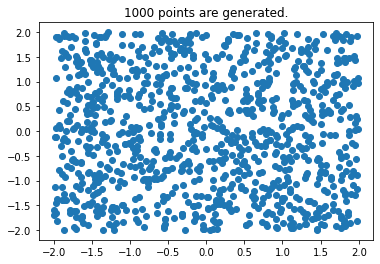

KeyboardInterrupt: ignored

In [71]:
#SPIRAL_DATA = generate_data_for_non_parameterized_dynamical_system(1000, vector_field_spiral, 2000).to(device)
#torch.save(SPIRAL_DATA, 'SPIRAL_DATA_1000_2000.pt')
SPIRAL_DATA = torch.load('SPIRAL_DATA_1000_2000.pt')

In [86]:
SPIRAL_DATA.shape

torch.Size([380209, 4])

In [18]:
def train_rungekutta_func(BIFURCATION_DATASET, epochs = 1000, M=3, H = 128):
  import time
  print("BIFURCATION_DATASET.shape {}".format(BIFURCATION_DATASET.shape))
  N = len(BIFURCATION_DATASET) # Size of dataset

  M=M  # input_size
  D=2   # output_size
  H=H # hidden_size
  model, loss_fn, optimizer = rungekutta_model(M, D, H) # defaults: input_size=3, output_size=2, hidden_size=128

  num_train, num_val, num_test = int(N * 0.6), int(N * 0.3), int(N * 0.1)

  np.random.seed(0)
  indices = np.random.permutation(N)
  train_idx, val_idx, test_idx = indices[:num_train], indices[num_train:num_train + num_val], indices[num_train + num_val:]
  #print("BIFURCATION_DATASET.shape {}".format(BIFURCATION_DATASET.shape))
  batch_size = 32
  batch_num = math.floor(N/batch_size)
  #print("train_idx {}".format(train_idx))
  batched_train_idxs = np.array_split(train_idx, batch_num)
  #print("batched_train_idxs.shape {}".format(batched_train_idxs))
  X = BIFURCATION_DATASET[:,:M]
  X_1 = BIFURCATION_DATASET[:,M:]
  val_loss_arr = []

  dt = torch.tensor(0.1).to(device).float()
  for t in range(epochs):
    train_epoch_loss = 0.0
    seconds = time.time()
    for batch_idx in batched_train_idxs:
      x_0_with_alpha = X[batch_idx].float()
      x_1 = X_1[batch_idx].float()

      #find k1,
      f, prediction = model(x_0_with_alpha, dt) # NxM => NxD

      # Compute and print loss.
      loss = loss_fn(prediction, x_1)
      train_epoch_loss += loss

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

    model.eval()
    with torch.no_grad():
      train_epoch_loss /= len(train_idx)
      _, pred = model(X[val_idx].float(), dt)
      validation_loss = loss_fn(pred, X_1[val_idx].float())
      val_loss_arr.append(validation_loss)
      print('(Epoch %d / %d, seconds: %d) train loss: %f validation loss: %f' % (t + 1, epochs, (time.time()-seconds), train_epoch_loss, validation_loss))
    model.train()
  plot_loss_curve(val_loss_arr)
  return model

BIFURCATION_DATASET.shape torch.Size([380209, 4])
(Epoch 1 / 28, seconds: 77) train loss: 0.000080 validation loss: 0.001264
(Epoch 2 / 28, seconds: 76) train loss: 0.000067 validation loss: 0.001239
(Epoch 3 / 28, seconds: 76) train loss: 0.000066 validation loss: 0.001226
(Epoch 4 / 28, seconds: 76) train loss: 0.000065 validation loss: 0.001215
(Epoch 5 / 28, seconds: 77) train loss: 0.000065 validation loss: 0.001210
(Epoch 6 / 28, seconds: 78) train loss: 0.000065 validation loss: 0.001206
(Epoch 7 / 28, seconds: 77) train loss: 0.000064 validation loss: 0.001205
(Epoch 8 / 28, seconds: 76) train loss: 0.000064 validation loss: 0.001204
(Epoch 9 / 28, seconds: 77) train loss: 0.000064 validation loss: 0.001204
(Epoch 10 / 28, seconds: 76) train loss: 0.000064 validation loss: 0.001203
(Epoch 11 / 28, seconds: 78) train loss: 0.000064 validation loss: 0.001203
(Epoch 12 / 28, seconds: 78) train loss: 0.000064 validation loss: 0.001203
(Epoch 13 / 28, seconds: 78) train loss: 0.0000

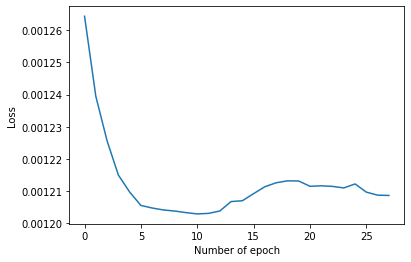

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RungeKutta. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [35]:
trained_model_runge_spiral = train_rungekutta_func(SPIRAL_DATA, epochs = 28, M=2, H = 128)
torch.save(trained_model_runge_spiral,'./trained_model_runge_spiral.pt')

In [51]:
def visualize_trajectories(trajectories, points, x_lim=-4, y_lim=4):
    fig, axs = plt.subplots(1, len(trajectories), figsize=(3 * len(points), 3))
    for i, trajectory in enumerate(trajectories):
        axs[i].scatter(trajectory[:, 0], trajectory[:, 1], linewidth=1, s=1, color="teal")
        axs[i].set_title('Point: {}'.format(points[i]))
        axs[i].set_xlim([x_lim, y_lim])
        axs[i].set_ylim([x_lim, y_lim])
    plt.show()

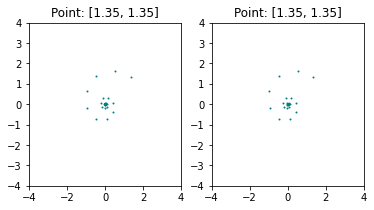

In [70]:
point = [1.35, 1.35]
duration = 100
time_step = 0.1
points = np.empty((1, 4))
t = 0
p = np.array(point)

torch_time_step = torch.tensor(time_step).to(device).float()

while t < duration:
    f, x_1 = trained_model_runge_spiral(torch.from_numpy(p.reshape(1, 2)).to(device).float(), torch_time_step)
    x_1 = x_1.detach().cpu().numpy()

    row = np.append(p, x_1).reshape(1, 4)

    points = np.vstack((points, row))

    p = x_1
    t += time_step
    
trajectory_1 = torch.from_numpy(points).float()
visualize_trajectories([trajectory_1,trajectory_1], [point, point])

# ELLIPTIC FUNCTION


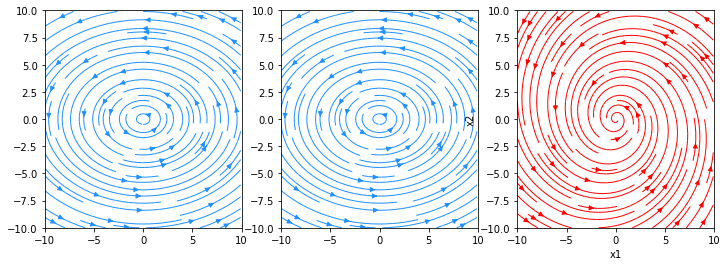

In [20]:
x = np.arange(-10, 10, 0.1)

x1, x2 = np.meshgrid(x, x)
y1 = -x2
y2 = x1 / 2

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].streamplot(x1, x2, y1, y2, color='dodgerblue', linewidth=1)
axs[0].set_xlim([-10, 10])
axs[0].set_ylim([-10, 10])

y1 = -x2
y2 = x1 / 2.0
axs[1].streamplot(x1, x2, y1, y2, color='dodgerblue', linewidth=1)
axs[1].set_xlim([-10, 10])
axs[1].set_ylim([-10, 10])

y1= -0.1 * x1 - 0.5 * x2
y2= 0.5 * x1 - 0.1 * x2
axs[2].streamplot(x1, x2, y1, y2, color='red', linewidth=1)
axs[2].set_xlim([-10, 10])
axs[2].set_ylim([-10, 10])

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

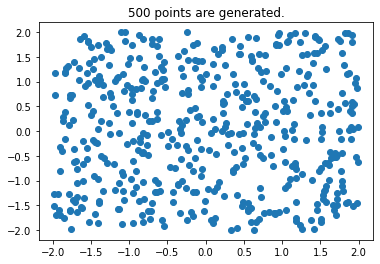

(366487) points are generated


In [21]:
ELLIPTIC_DATA = generate_data_for_non_parameterized_dynamical_system(500, vector_field_ellipse, 1000).to(device)
torch.save(ELLIPTIC_DATA, 'ELLIPTIC_DATA_500_1000.pt')

BIFURCATION_DATASET.shape torch.Size([366487, 4])
(Epoch 1 / 10, seconds: 77) train loss: 0.000924 validation loss: 0.002649
(Epoch 2 / 10, seconds: 77) train loss: 0.000148 validation loss: 0.002587
(Epoch 3 / 10, seconds: 75) train loss: 0.000146 validation loss: 0.002562
(Epoch 4 / 10, seconds: 75) train loss: 0.000144 validation loss: 0.002550
(Epoch 5 / 10, seconds: 76) train loss: 0.000144 validation loss: 0.002539
(Epoch 6 / 10, seconds: 74) train loss: 0.000143 validation loss: 0.002531
(Epoch 7 / 10, seconds: 76) train loss: 0.000142 validation loss: 0.002529
(Epoch 8 / 10, seconds: 76) train loss: 0.000142 validation loss: 0.002526
(Epoch 9 / 10, seconds: 77) train loss: 0.000142 validation loss: 0.002523
(Epoch 10 / 10, seconds: 76) train loss: 0.000141 validation loss: 0.002523


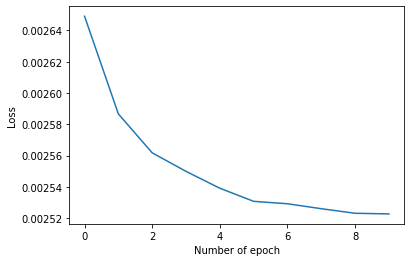

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RungeKutta. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [64]:
trained_model_runge_elliptic = train_rungekutta_func(ELLIPTIC_DATA, epochs = 10, M=2, H = 128)
torch.save(trained_model_runge_elliptic,'./trained_model_runge_elliptic.pt')

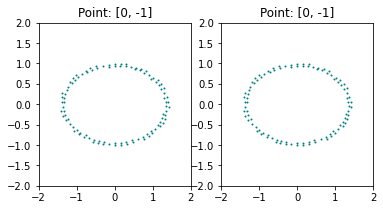

In [68]:
point = [0, -1]
duration = 10
time_step = 0.1
points = np.empty((1, 4))
t = 0
p = np.array(point)

torch_time_step = torch.tensor(time_step).to(device).float()

while t < duration:
    f, x_1 = trained_model_runge_elliptic(torch.from_numpy(p.reshape(1, 2)).to(device).float(), torch_time_step)
    x_1 = x_1.detach().cpu().numpy()

    row = np.append(p, x_1).reshape(1, 4)

    points = np.vstack((points, row))

    p = x_1
    t += time_step
    
trajectory_1 = torch.from_numpy(points).float()
visualize_trajectories([trajectory_1,trajectory_1], [point, point], x_lim=-2, y_lim=2)

# EULER ON SPIRAL AND ELLIPTIC FUNCTION

In [22]:
def train_euler_func(BIFURCATION_DATASET, epochs = 1000, H = 128, M=3):
  import time
  print("BIFURCATION_DATASET.shape {}".format(BIFURCATION_DATASET.shape))
  N = len(BIFURCATION_DATASET) # Size of dataset

  M=M   # input_size
  D=2   # output_size
  H=H # hidden_size
  model, loss_fn, optimizer = euler_model(M, D, H) # defaults: input_size=3, output_size=2, hidden_size=128

  num_train, num_val, num_test = int(N * 0.6), int(N * 0.3), int(N * 0.1)

  np.random.seed(0)
  indices = np.random.permutation(N)
  train_idx, val_idx, test_idx = indices[:num_train], indices[num_train:num_train + num_val], indices[num_train + num_val:]
  #print("BIFURCATION_DATASET.shape {}".format(BIFURCATION_DATASET.shape))
  batch_size = 32
  batch_num = math.floor(N/batch_size)
  #print("train_idx {}".format(train_idx))
  batched_train_idxs = np.array_split(train_idx, batch_num)
  #print("batched_train_idxs.shape {}".format(batched_train_idxs))
  X = BIFURCATION_DATASET[:,:M]
  X_1 = BIFURCATION_DATASET[:,M:]
  
  val_loss_arr = []
  
  dt = torch.tensor(0.1).to(device).float()
  for t in range(epochs):
    train_epoch_loss = 0.0
    seconds = time.time()
    for batch_idx in batched_train_idxs:
      x_0_with_alpha = X[batch_idx].float()
      x_1 = X_1[batch_idx].float()

      _, y_pred = model(x_0_with_alpha, dt) # NxM => NxD

      # Compute and print loss.
      loss = loss_fn(y_pred, x_1)
      train_epoch_loss += loss

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

    model.eval()
    with torch.no_grad():
      train_epoch_loss /= len(train_idx)
      _, pred = model(X[val_idx].float(), dt)
      validation_loss = loss_fn(pred, X_1[val_idx].float())
      val_loss_arr.append(validation_loss)
      print('(Epoch %d / %d, seconds: %d) train loss: %f validation loss: %f' % (t + 1, epochs, (time.time()-seconds), train_epoch_loss, validation_loss))
    model.train()
  plot_loss_curve(val_loss_arr)
  return model

BIFURCATION_DATASET.shape torch.Size([380209, 4])
(Epoch 1 / 50, seconds: 34) train loss: 0.000079 validation loss: 0.001268
(Epoch 2 / 50, seconds: 34) train loss: 0.000068 validation loss: 0.001249
(Epoch 3 / 50, seconds: 35) train loss: 0.000067 validation loss: 0.001236
(Epoch 4 / 50, seconds: 35) train loss: 0.000066 validation loss: 0.001223
(Epoch 5 / 50, seconds: 35) train loss: 0.000065 validation loss: 0.001213
(Epoch 6 / 50, seconds: 35) train loss: 0.000065 validation loss: 0.001206
(Epoch 7 / 50, seconds: 35) train loss: 0.000064 validation loss: 0.001200
(Epoch 8 / 50, seconds: 35) train loss: 0.000064 validation loss: 0.001196
(Epoch 9 / 50, seconds: 35) train loss: 0.000064 validation loss: 0.001194
(Epoch 10 / 50, seconds: 34) train loss: 0.000064 validation loss: 0.001192
(Epoch 11 / 50, seconds: 34) train loss: 0.000063 validation loss: 0.001192
(Epoch 12 / 50, seconds: 35) train loss: 0.000063 validation loss: 0.001189
(Epoch 13 / 50, seconds: 35) train loss: 0.0000

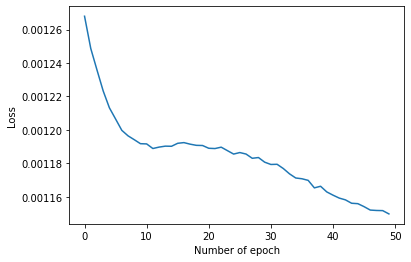

BIFURCATION_DATASET.shape torch.Size([366487, 4])
(Epoch 1 / 60, seconds: 35) train loss: 0.000895 validation loss: 0.002565
(Epoch 2 / 60, seconds: 34) train loss: 0.000147 validation loss: 0.002536
(Epoch 3 / 60, seconds: 34) train loss: 0.000145 validation loss: 0.002523
(Epoch 4 / 60, seconds: 33) train loss: 0.000144 validation loss: 0.002522
(Epoch 5 / 60, seconds: 34) train loss: 0.000143 validation loss: 0.002510
(Epoch 6 / 60, seconds: 34) train loss: 0.000142 validation loss: 0.002504
(Epoch 7 / 60, seconds: 34) train loss: 0.000142 validation loss: 0.002506
(Epoch 8 / 60, seconds: 34) train loss: 0.000141 validation loss: 0.002509
(Epoch 9 / 60, seconds: 33) train loss: 0.000141 validation loss: 0.002507
(Epoch 10 / 60, seconds: 33) train loss: 0.000141 validation loss: 0.002506
(Epoch 11 / 60, seconds: 33) train loss: 0.000141 validation loss: 0.002505
(Epoch 12 / 60, seconds: 33) train loss: 0.000140 validation loss: 0.002504
(Epoch 13 / 60, seconds: 34) train loss: 0.0001

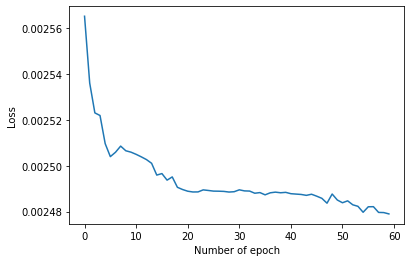

In [23]:
trained_model_euler_spiral = train_euler_func(SPIRAL_DATA, epochs = 50, H = 128, M=2)
trained_model_euler_elliptic = train_euler_func(ELLIPTIC_DATA, epochs = 60, H = 128, M=2)
torch.save(trained_model_euler_spiral,'./trained_model_euler_spiral.pt')
torch.save(trained_model_euler_elliptic,'./trained_model_euler_elliptic.pt')

#trained_model_euler_spiral = torch.load(./trained_model_euler_spiral.pt)
#trained_model_euler_spiral.eval()

#trained_model_euler_elliptic = torch.load(./trained_model_euler_elliptic.pt)
#trained_model_euler_elliptic.eval()

In [32]:
torch.save(trained_model_euler_spiral,'./trained_model_euler_spiral.pt')
torch.save(trained_model_euler_elliptic,'./trained_model_euler_elliptic.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Eueler. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Plots left to right: Euler-Spiral, RK-4-Spiral, Euler-Elliptic, RK-4-Elliptic
Time step is 0.01


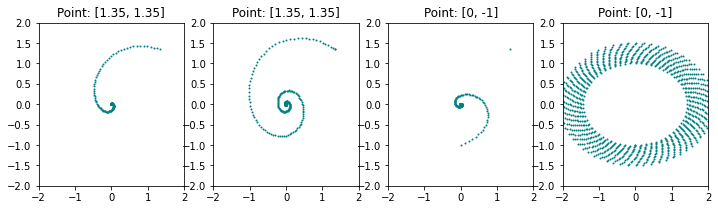

Time step is 0.02


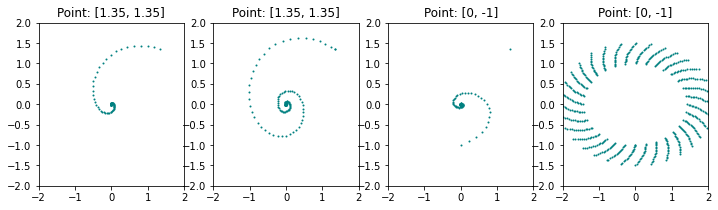

Time step is 0.03


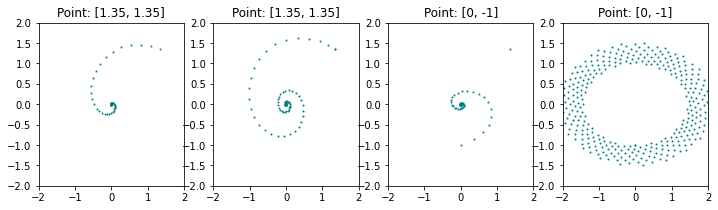

Time step is 0.04


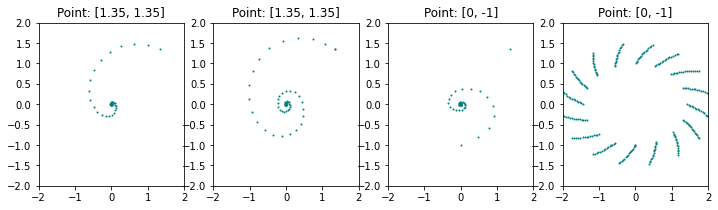

Time step is 0.05


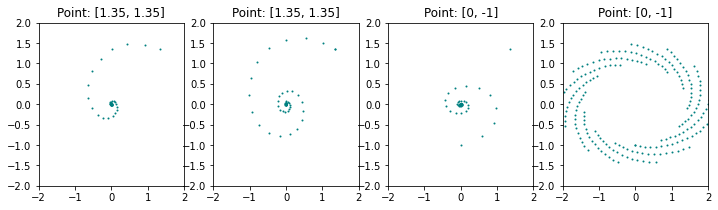

Time step is 0.06


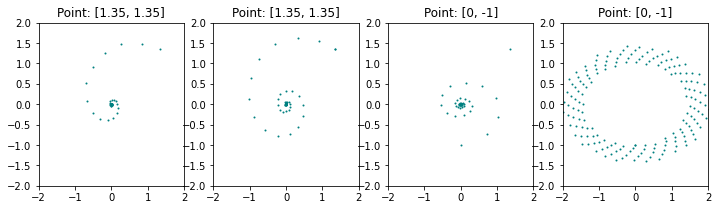

Time step is 0.07


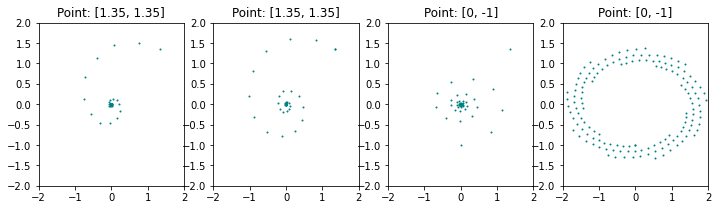

Time step is 0.08


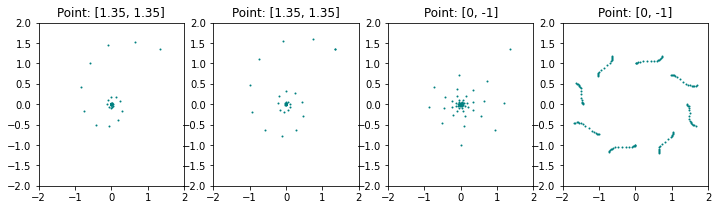

Time step is 0.09


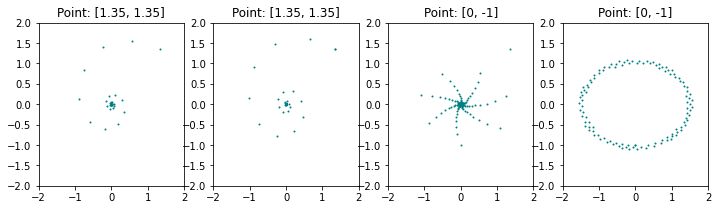

Time step is 0.1


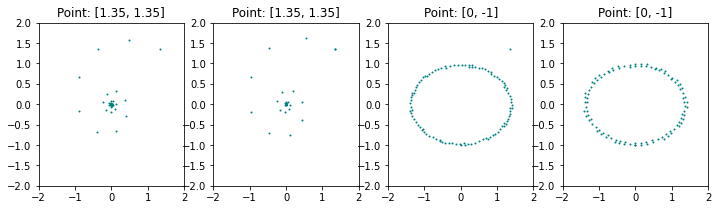

Time step is 0.12


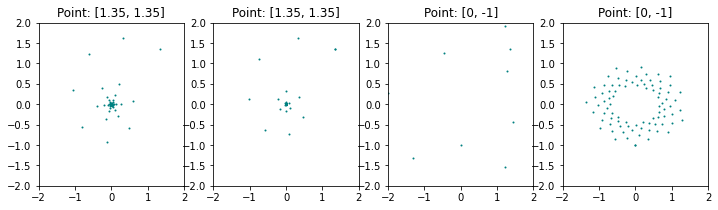

Time step is 0.15


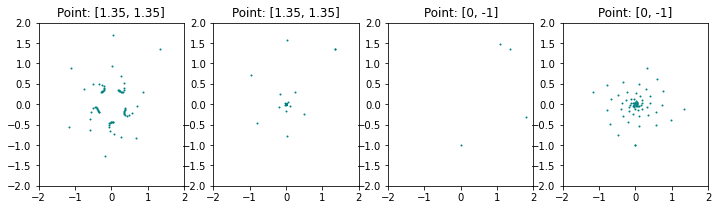

Time step is 0.2


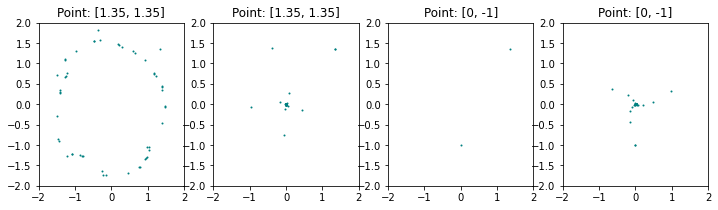

In [78]:
def get_trajectory(model, point, dt, duration = 10):
  time_step = dt
  points = np.empty((1, 4))
  t = 0
  p = np.array(point)

  torch_time_step = torch.tensor(time_step).to(device).float()

  while t < duration:
      f, x_1 = model(torch.from_numpy(p.reshape(1, 2)).to(device).float(), torch_time_step)
      x_1 = x_1.cpu().detach().numpy()

      row = np.append(p, x_1).reshape(1, 4)

      points = np.vstack((points, row))

      p = x_1
      t += time_step
      
  return torch.from_numpy(points).float()
  
print("Plots left to right: Euler-Spiral, RK-4-Spiral, Euler-Elliptic, RK-4-Elliptic")
for dt in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.15, 0.2]:
  print("Time step is {}".format(dt))
  trajectory_1 = get_trajectory(trained_model_euler_spiral.to(device), [1.35, 1.35], dt)
  trajectory_3 = get_trajectory(trained_model_runge_spiral.to(device), [1.35, 1.35], dt)
  trajectory_2 = get_trajectory(trained_model_euler_elliptic.to(device), [0, -1], dt)
  trajectory_4 = get_trajectory(trained_model_runge_elliptic.to(device), [0, -1], dt)
  visualize_trajectories([trajectory_1,trajectory_3,trajectory_2,trajectory_4], [[1.35, 1.35], [1.35, 1.35], [0, -1], [0, -1]], x_lim=-2, y_lim=2)

# GENERATE DATA BY HAND CALCULATION NOT SOLVE_IVP
Since solve.ivp determines the time step adaptively, we will test the network with fixed time step

In [36]:
def generate_trajectory_by_euler(start_point, fun=vector_field_ellipse, alpha=None, duration=100,
                                 time_step=0.1):
    if alpha is None:
        M = 4
    else:
        M = 5
    points = np.empty((1, M))
    time = 0
    p = np.array(start_point)

    while time < duration:
        if alpha is None:
            f = fun(time_step, x=p)
            x_0_alpha = p
        else:
            f = fun(time_step, x=p, alpha=alpha)
            x_0_alpha = np.append(p, alpha)
        x_1 = p + np.array(f) * time_step

        row = np.append(x_0_alpha, x_1).reshape(1, M)

        points = np.vstack((points, row))

        p = x_1
        time += time_step
    return torch.from_numpy(points).float()

In [39]:
# Same with generate_data_for_non_parameterized_dynamical_system, BUT we will use euler integrator instead of solve_ivp!
def generate_data_for_non_parameterized_dynamical_system_with_euler(num_points, fun=vector_field_ellipse, duration=100,
                                                         show_plot=True,
                                                         time_step=0.1):
    x = np.random.uniform(-2, 2, num_points)
    y = np.random.uniform(-2, 2, num_points)

    if show_plot:
        fig, ax = plt.subplots()
        ax.scatter(x, y)
        ax.set_title("{} points are generated.".format(num_points))
        plt.show()

    DATAPOINTS = None

    for i, j in tuple(zip(x, y)):
        trajectory = generate_trajectory_by_euler([i, j], fun, None, duration, time_step)
        if DATAPOINTS is None:
            DATAPOINTS = trajectory
        else:
            DATAPOINTS = torch.cat([DATAPOINTS, trajectory], dim=0)

    print("({}) points are generated".format(len(DATAPOINTS)))

    return DATAPOINTS

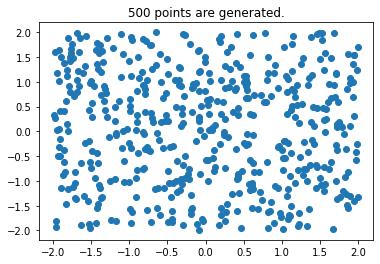

(501000) points are generated


In [45]:
SPIRAL_DATA_EULER_DT_0_1 = generate_data_for_non_parameterized_dynamical_system_with_euler(500, vector_field_spiral, 100, time_step=0.1).to(device)
torch.save(SPIRAL_DATA_EULER_DT_0_1, 'SPIRAL_DATA_EULER_500_100_DT_0_1.pt')

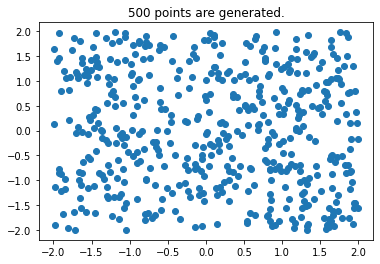

(501000) points are generated


In [46]:
ELLIPTIC_DATA_EULER_DT_0_1 = generate_data_for_non_parameterized_dynamical_system_with_euler(500, vector_field_ellipse, 100, time_step=0.1).to(device)
torch.save(ELLIPTIC_DATA_EULER_DT_0_1, 'ELLIPTIC_DATA_EULER_500_100_DT_0_1.pt')

BIFURCATION_DATASET.shape torch.Size([501000, 4])
(Epoch 1 / 2, seconds: 46) train loss: 0.000051 validation loss: 0.000000
(Epoch 2 / 2, seconds: 46) train loss: 0.000049 validation loss: 0.000000


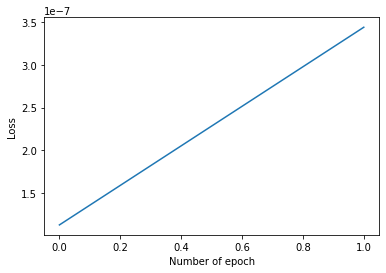

BIFURCATION_DATASET.shape torch.Size([501000, 4])
(Epoch 1 / 2, seconds: 46) train loss: 0.000204 validation loss: 0.000005
(Epoch 2 / 2, seconds: 47) train loss: 0.000098 validation loss: 0.000007


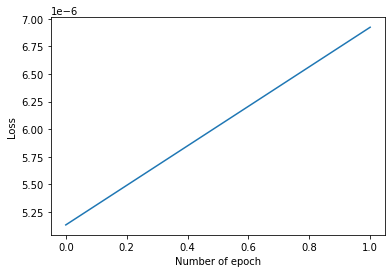

In [60]:
trained_model_euler_spiral_dt_0_1 = train_euler_func(SPIRAL_DATA_EULER_DT_0_1, epochs = 2, H = 64, M=2)
trained_model_euler_elliptic_dt_0_1 = train_euler_func(ELLIPTIC_DATA_EULER_DT_0_1, epochs = 2, H = 64, M=2)

Time step is 0.1


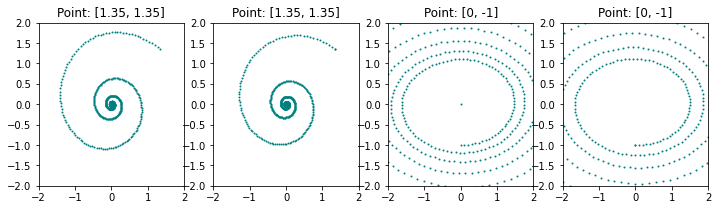

In [79]:
duration = 100
for dt in [0.1]:
  print("Time step is {}".format(dt))
  trajectory_1 = get_trajectory(trained_model_euler_spiral_dt_0_1, [1.35, 1.35], dt, duration)
  trajectory_2 = generate_trajectory_by_euler([1.35, 1.35], vector_field_spiral, None, duration, dt)
  trajectory_3 = get_trajectory(trained_model_euler_elliptic_dt_0_1, [0, -1], dt, duration)
  trajectory_4 = generate_trajectory_by_euler([0, -1], vector_field_ellipse, None, duration, dt)
  visualize_trajectories([trajectory_1,trajectory_2,trajectory_3,trajectory_4], [[1.35, 1.35], [1.35, 1.35], [0, -1], [0, -1]], x_lim=-2, y_lim=2)

Time step is 0.01


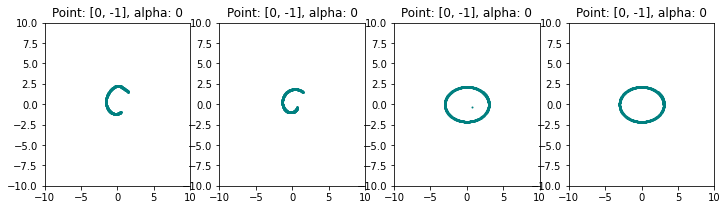

Time step is 0.02


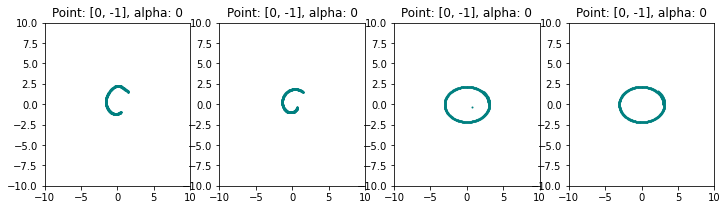

Time step is 0.03


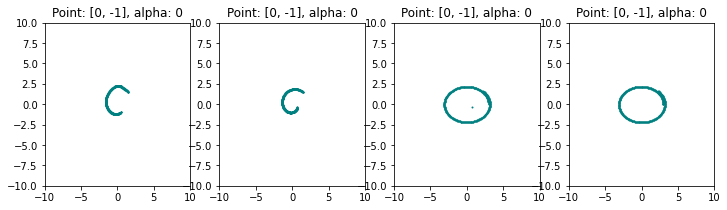

Time step is 0.04


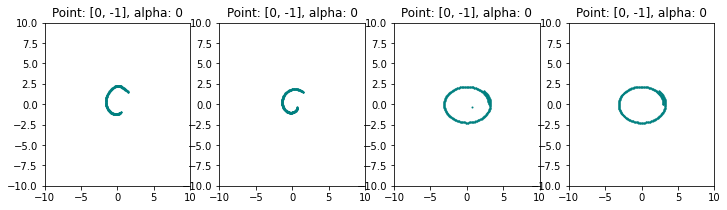

Time step is 0.05


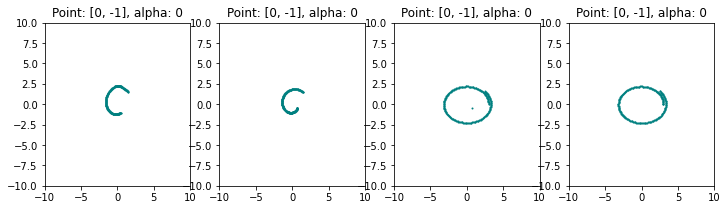

Time step is 0.06


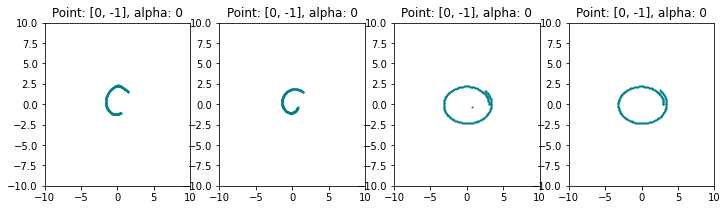

Time step is 0.07


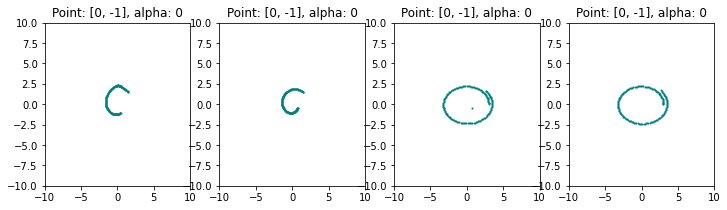

Time step is 0.08


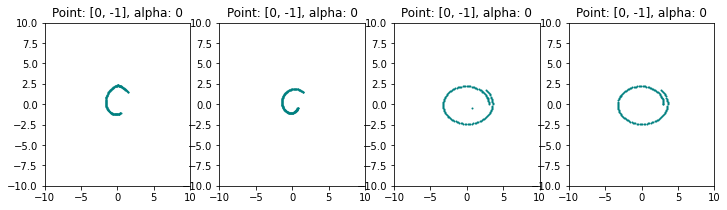

Time step is 0.09


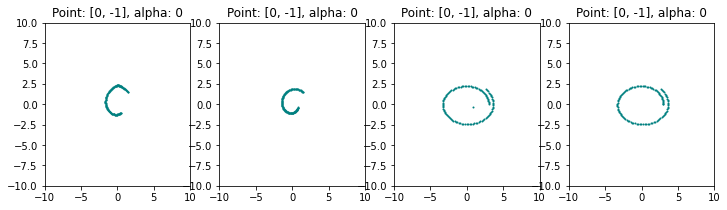

Time step is 0.1


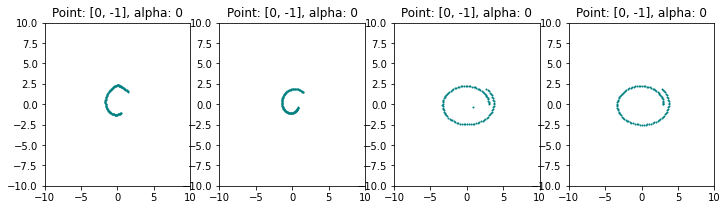

Time step is 0.12


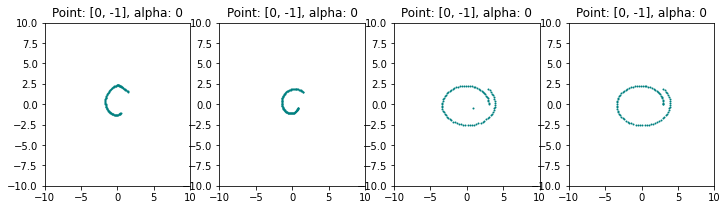

Time step is 0.15


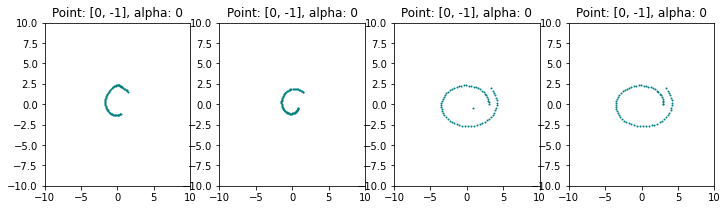

Time step is 0.2


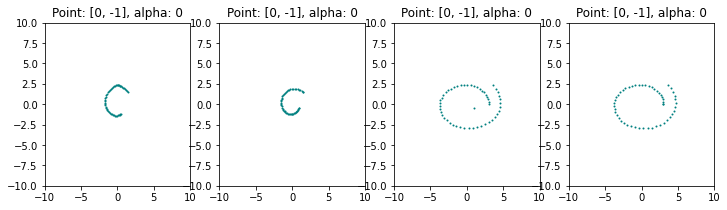

In [108]:
duration = 100
for dt in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.15, 0.2]:
  print("Time step is {}".format(dt))
  trajectory_1 = get_trajectory(trained_model_euler_spiral_dt_0_1, [1.35, 1.35], dt, duration)
  trajectory_2 = generate_trajectory_by_euler([1.35, 1.35], vector_field_spiral, None, duration, dt)
  trajectory_3 = get_trajectory(trained_model_euler_elliptic_dt_0_1, [0, -1], dt, duration)
  trajectory_4 = generate_trajectory_by_euler([0, -1], vector_field_ellipse, None, duration, dt)
  visualize_trajectories([trajectory_1,trajectory_2,trajectory_3,trajectory_4], [[1.35, 1.35], [1.35, 1.35], [0, -1], [0, -1]], x_lim=-2, y_lim=2)

In [ ]:
def generate_trajectory_by_runge_kutta(start_point, fun=vector_field_ellipse, alpha=None, duration=100,
                                 time_step=0.1):
        if alpha is None:
        M = 4
    else:
        M = 5
    points = np.empty((1, M))
    time = 0
    p = np.array(start_point)

    while time < duration:
        if alpha is None:
            f = fun(time_step, x=p)
            k1 = np.array(f) * time_step

            f = fun(time_step, x=(p + k1 / 2))
            k2 = np.array(f) * time_step

            f = fun(time_step, x=(p + k2 / 2))
            k3 = np.array(f) * time_step

            f = fun(time_step, x=(p + k3))
            k4 = np.array(f) * time_step
        else:
            f = fun(time_step, x=p, alpha=alpha)
            k1 = np.array(f) * time_step

            f = fun(time_step, x=(p + k1 / 2), alpha=alpha)
            k2 = np.array(f) * time_step

            f = fun(time_step, x=(p + k2 / 2), alpha=alpha)
            k3 = np.array(f) * time_step

            f = fun(time_step, x=(p + k3), alpha=alpha)
            k4 = np.array(f) * time_step

        x_1 = p + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6

        if alpha is None:
            x_0_alpha = p
        else:
            x_0_alpha = np.append(p, alpha)

        row = np.append(x_0_alpha, x_1).reshape(1, M)

        points = np.vstack((points, row))

        p = x_1
        time += time_step
    return torch.from_numpy(points).float()

In [ ]:
# Same with generate_data_for_non_parameterized_dynamical_system, BUT we will use euler integrator instead of solve_ivp!
def generate_data_for_non_parameterized_dynamical_system_with_runge_kutta(num_points, fun=vector_field_ellipse, duration=100,
                                                         show_plot=True,
                                                         time_step=0.1):
    x = np.random.uniform(-2, 2, num_points)
    y = np.random.uniform(-2, 2, num_points)

    if show_plot:
        fig, ax = plt.subplots()
        ax.scatter(x, y)
        ax.set_title("{} points are generated.".format(num_points))
        plt.show()

    DATAPOINTS = None

    for i, j in tuple(zip(x, y)):
        trajectory = generate_trajectory_by_runge_kutta([i, j], fun, None, duration, time_step)
        if DATAPOINTS is None:
            DATAPOINTS = trajectory
        else:
            DATAPOINTS = torch.cat([DATAPOINTS, trajectory], dim=0)

    print("({}) points are generated".format(len(DATAPOINTS)))

    return DATAPOINTS

In [ ]:
SPIRAL_DATA_RUNGE_DT_0_1 = generate_data_for_non_parameterized_dynamical_system_with_runge_kutta(500, vector_field_spiral, 1000, time_step=0.1).to(device)
torch.save(SPIRAL_DATA_RUNGE_DT_0_1, 'SPIRAL_DATA_RUNGE_500_1000_DT_0_1.pt')

ELLIPTIC_DATA_RUNGE_DT_0_1 = generate_data_for_non_parameterized_dynamical_system_with_runge_kutta(500, vector_field_ellipse, 1000, time_step=0.1).to(device)
torch.save(ELLIPTIC_DATA_RUNGE_DT_0_1, 'ELLIPTIC_DATA_RUNGE_500_1000_DT_0_1.pt')

In [ ]:
trained_model_runge_spiral_dt_0_1 = train_rungekutta_func(SPIRAL_DATA_RUNGE_DT_0_1, epochs = 10, H = 128, M=2)
trained_model_runge_elliptic_dt_0_1 = train_rungekutta_func(ELLIPTIC_DATA_RUNGE_DT_0_1, epochs = 10, H = 128, M=2)